In [1]:
import os

os.chdir("../..")
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import copy
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from modular_splicing.case_study.yang.pipeline import asb_table, attach_exons_to_asb

In [5]:
asb = asb_table()

In [6]:
exons_per_asb = copy.deepcopy(attach_exons_to_asb())

In [7]:
def deduplicate_rows(table):
    return table[~table.duplicated()]


def deduplicate_rows_without_cell_line(table):
    return table[~table[[x for x in table if x != "cell" and x != "dPSI"]].duplicated()]

In [8]:
exons_per_asb_deduplicated = [deduplicate_rows(t) for t in exons_per_asb]
exons_per_asb_deduplicated_without_cell_line = [
    deduplicate_rows_without_cell_line(t) for t in exons_per_asb
]

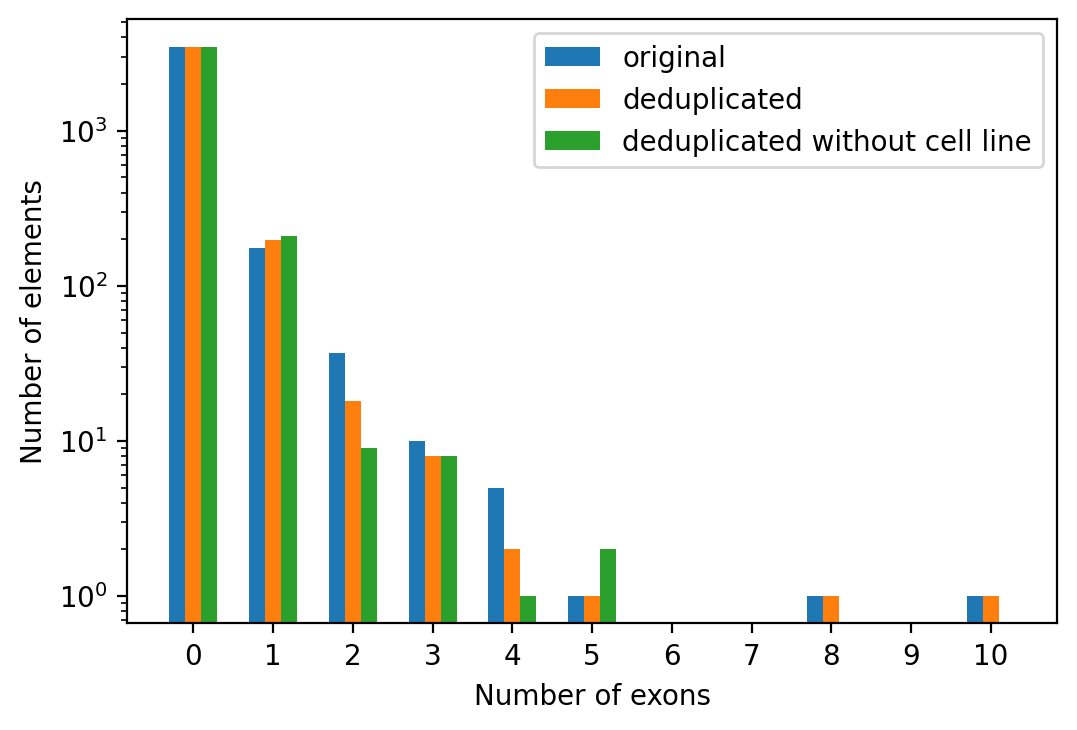

In [9]:
dist = 0.2
bar = 0.2

num_matches = [x.shape[0] for x in exons_per_asb]
num_deduplicated = [x.shape[0] for x in exons_per_asb_deduplicated]
num_deduplicated_without_cell_lines = [
    x.shape[0] for x in exons_per_asb_deduplicated_without_cell_line
]
bins = np.arange(max(num_matches) + 1)


def pbar(elements, off, **kwargs):
    counts = Counter(elements)
    counts = [counts[b] for b in bins]
    plt.bar(bins + off, counts, width=bar, **kwargs)


plt.figure(dpi=200)
pbar(num_matches, -dist, label="original")
pbar(num_deduplicated, 0, label="deduplicated")
pbar(
    num_deduplicated_without_cell_lines,
    dist,
    label="deduplicated without cell line",
)
plt.yscale("log")
plt.xticks(bins)
plt.legend()
plt.xlabel("Number of exons")
plt.ylabel("Number of elements")
plt.show()

In [10]:
result_table = []
for nd, ex, (_, row) in zip(
    tqdm.tqdm(num_deduplicated_without_cell_lines), exons_per_asb, asb.iterrows()
):
    ex = ex.copy()
    ex["Number duplicates"] = nd
    for col in row.index:
        ex[f"asb_{col}"] = row[col]
    result_table.append(ex)

In [11]:
result_table = pd.concat(result_table)

In [12]:
result_table.to_csv("output-csvs/case-study/yang/exons_per_asb.csv", index=False)